# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [27]:
# Load pickled data
import pickle

# TODO: fill this in based on where you saved the training and testing data
training_file = '../P2-Traffic-Sign-Classifier/train.p'
testing_file = '../P2-Traffic-Sign-Classifier/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [28]:
### To start off let's do a basic data summary.

# TODO: number of training examples
n_train = len(X_train)

# TODO: number of testing examples
n_test = len(y_train)

# TODO: what's the shape of an image?
image_shape = X_train.shape

# TODO: how many classes are in the dataset
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 39209
Image data shape = (39209, 32, 32, 3)
Number of classes = 43


In [29]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from skimage.feature import local_binary_pattern as lbp
from sklearn.utils import shuffle
from keras.preprocessing.image import ImageDataGenerator
import cv2
import random

In [30]:
import pandas as pd
from IPython.display import clear_output

signnames = pd.read_csv('signnames.csv')

translate = {}
for key, val in zip(signnames['ClassId'], signnames['SignName']):
    translate[key] = val

In [31]:
class Utils(object):
    
    def show_img(self, dshow,lshow = None, rows = 1):

        if len(dshow.shape) == 2 or (len(dshow.shape) == 3 and (dshow.shape[-1] == 2 or dshow.shape[-1] == 3)):
            size = 1
        else:
            size = dshow.shape[0]
            
        try:
            show_idx = random.sample(list(range(size)), rows*5)
        except ValueError:
            show_idx = np.random.randint(size, size=rows*5) #returns python list

        for i in range(rows):
            i *= 5
            if size != 1:

                f, (ax1, ax2, ax3,ax4,ax5) = plt.subplots(1, 5)
                f.set_size_inches(17,1.5)

                ax1.imshow(dshow[show_idx[i]])
                ax2.imshow(dshow[show_idx[i+1]])
                ax3.imshow(dshow[show_idx[i+2]])
                ax4.imshow(dshow[show_idx[i+3]])
                ax5.imshow(dshow[show_idx[i+4]])

                if lshow is not None:
                    ax1.set_title(lshow[show_idx[i]])
                    ax2.set_title(lshow[show_idx[i+1]])
                    ax3.set_title(lshow[show_idx[i+2]])
                    ax4.set_title(lshow[show_idx[i+3]])
                    ax5.set_title(lshow[show_idx[i+4]])

                plt.show(block=False)

            else:
                f, (ax1) = plt.subplots(1, 1)
                f.set_size_inches(17,1.5)

                ax1.imshow(dshow[show_idx[i]])

                if lshow is not None:
                    ax1.set_title( lshow[show_idx[i]] )

                plt.show(block=False)
    
    def normalize_grayscale(self, image_data, pixel_depth = 255):
        """
        Normalize the image data with Min-Max scaling to a range of [0.1, 0.9]
        :param image_data: The image data to be normalized
        :return: Normalized image data
        """
        return (image_data - pixel_depth / 2) / pixel_depth
    
    def np2grayscale(self, rgb):
        im0 = rgb.shape[1]
        im1 = rgb.shape[2]
        grays = np.zeros((rgb.shape[0], im0, im1, 1))
        for i, gray in enumerate(rgb):
            grays[i] = cv2.cvtColor(gray, cv2.COLOR_BGR2GRAY).reshape(im0, im1, 1)

        return grays
    
    def std(self, size):
        return math.sqrt(2.0/size)
    
    def basic_info(self, data):
        print('{} {} Min {} Max {} Mean {} std {}'.format(data.dtype,
                                                          data.shape,
                                                          round(np.min(data),2),
                                                          round(np.max(data),2),
                                                          round(np.mean(data),2),
                                                          round(np.std(data)),2))
    
    def accuracy(self, predictions, labels):
        #print(predictions,'\n-->\n',labels)
        return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))/ predictions.shape[0])

    def save(self, checkpoint_file, session, variables):
        file_to_save = checkpoint_file + '.chk'
        #chk - checkpoint
        print('\nVariables :', end=' ')
        for v in variables:
            print(v.name,end=' ')
        saver = tf.train.Saver(variables)
        saver.save(session, file_to_save)
        print('saved to',file_to_save)
    
    def add_lbp_channel_and_norm(self, image_data):
        imshape1 = image_data.shape[1]
        imshape2 = image_data.shape[2]
        
        radius = 3 ; n_points = 8 * radius
        image_lbp = np.zeros((image_data.shape))
        
        for i, im in enumerate(image_data):
            image_lbp[i] = lbp(im, n_points, radius, 'uniform')
        
        image_lbp = self.normalize_grayscale(image_lbp, 0, 255, 0, 1).astype(np.float32).reshape(-1,imshape1,imshape2,1)
        image_data = self.normalize_grayscale(image_data, 0, 255, 0, 1).astype(np.float32).reshape(-1,imshape1,imshape2,1)
        
        image_data = np.concatenate((image_data,image_lbp), axis=3)
        
        return image_data
    
    def prepare_training_data(self, dataset, datalabels, bin_size):
        for l in set(datalabels):
            pop_data = dataset[datalabels == l]
            pop_labels = datalabels[datalabels == l]
            current_count = len(pop_labels)
            for _ in range((bin_size // current_count)-1):
                dataset = np.concatenate((dataset, pop_data), axis=0)
                datalabels = np.concatenate((datalabels, pop_labels), axis=0)
        
        datagen = ImageDataGenerator(rotation_range=15,
                                     width_shift_range=0.06,
                                     height_shift_range=0.06,
                                     zoom_range=[0.9, 1.1],
                                     featurewise_center=True,
                                     featurewise_std_normalization=True)
        
        # fit parameters from data
        datagen.fit(dataset)
        for x, y in datagen.flow(dataset, datalabels, batch_size=len(datalabels), seed=23, shuffle=True):
            dataset = x
            datalabels = y
            break
        
        return dataset, datalabels, datagen
        
    
    def preprocess_images(self, dataset, datalabels, datagen = None):
        
        if datagen is None:
            datagen = ImageDataGenerator(featurewise_center=True,
                                         featurewise_std_normalization=True)

            # fit parameters from data
            datagen.fit(dataset)
        
        for x, y in datagen.flow(dataset, datalabels, batch_size=len(datalabels), seed=47, shuffle=True):
            dataset = x
            datalabels = y
            break
        
        return dataset, datalabels

utils = Utils()

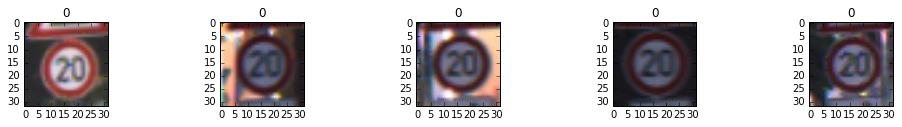

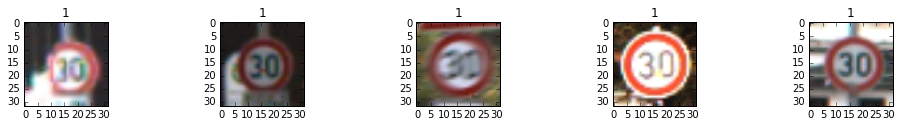

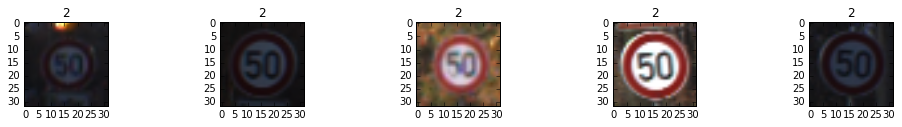

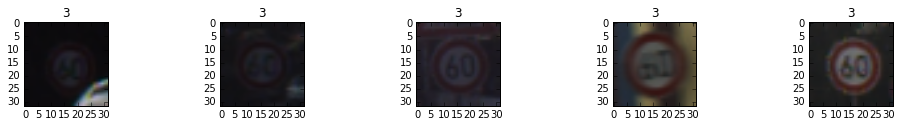

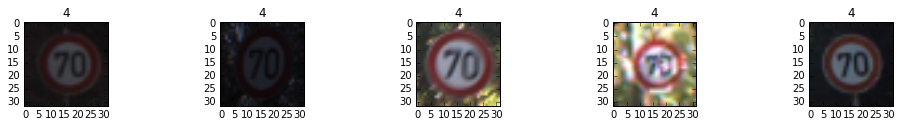

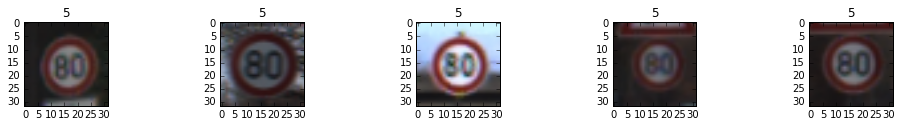

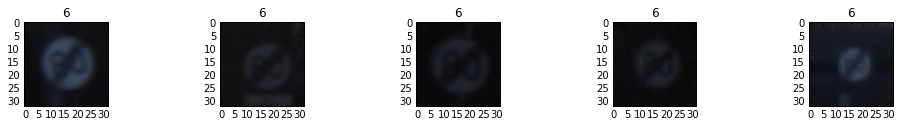

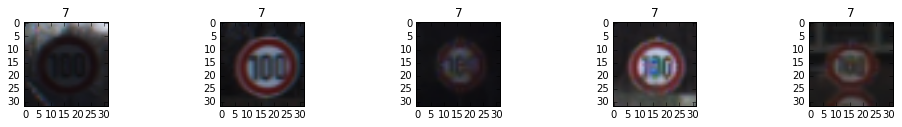

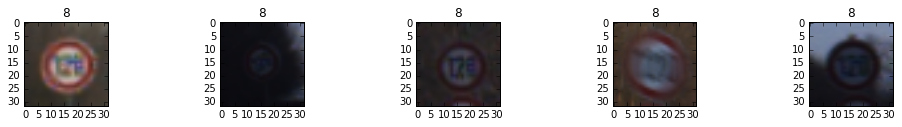

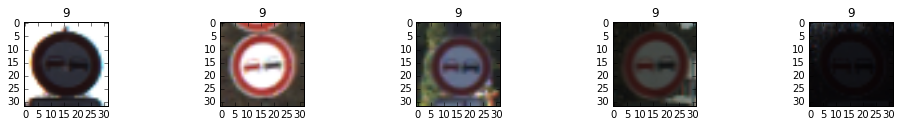

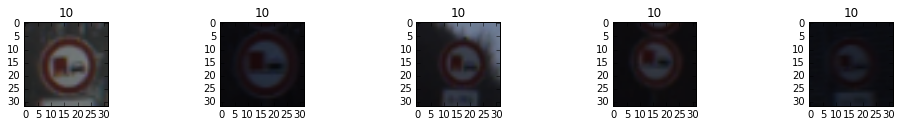

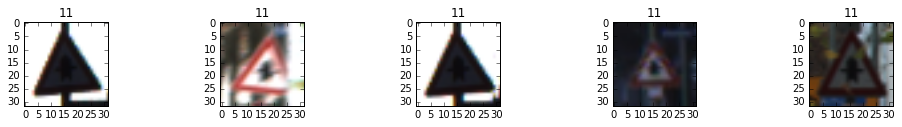

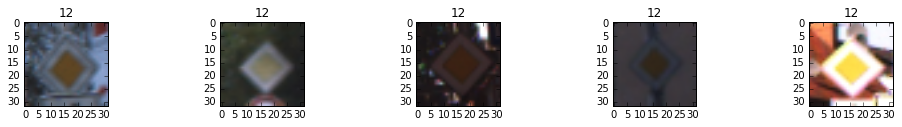

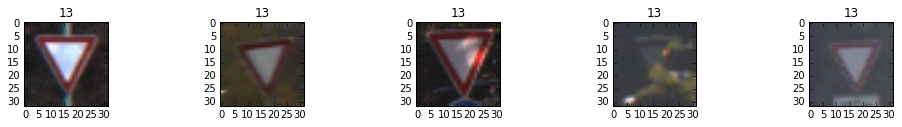

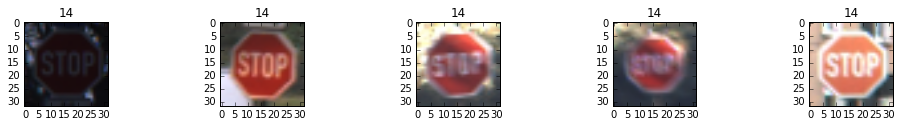

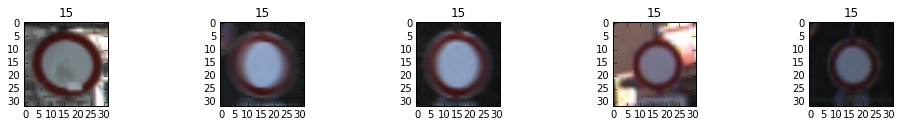

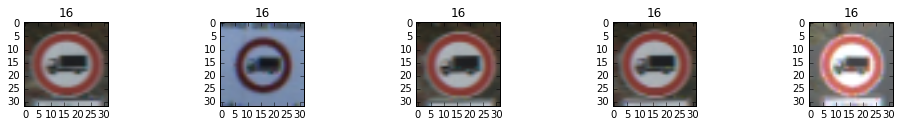

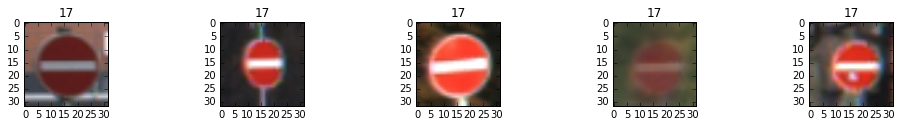

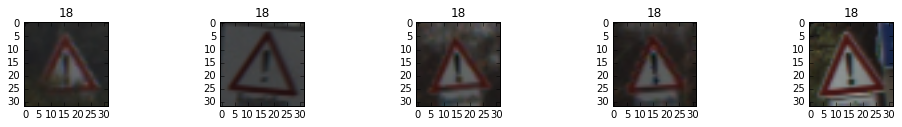

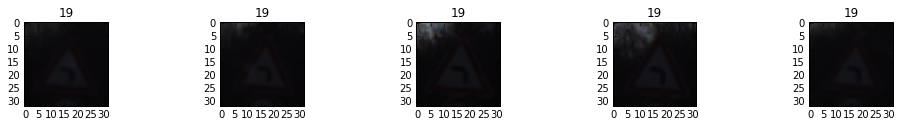

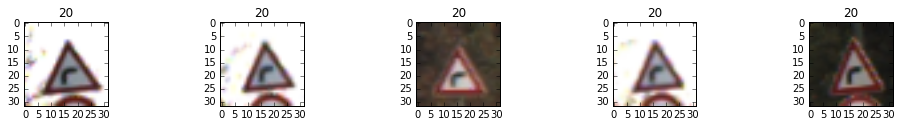

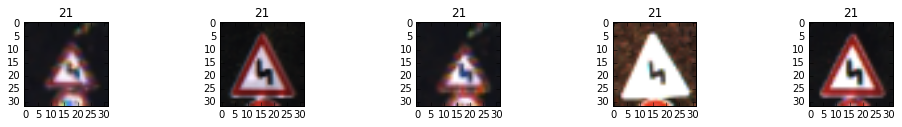

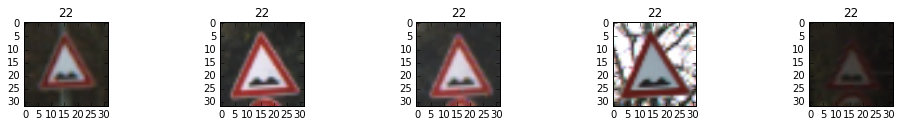

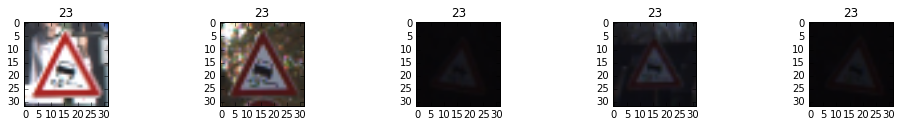

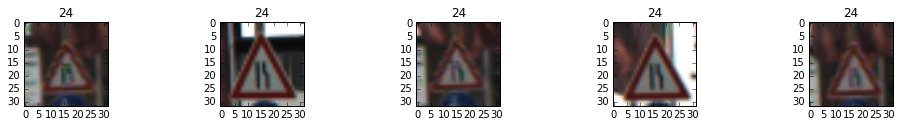

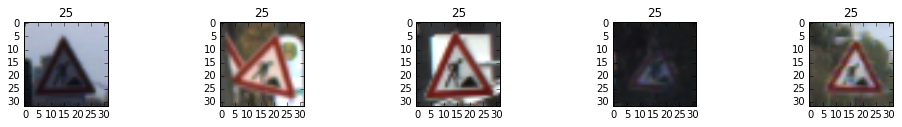

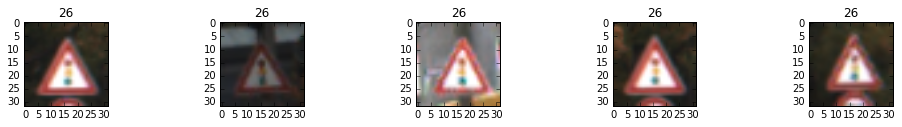

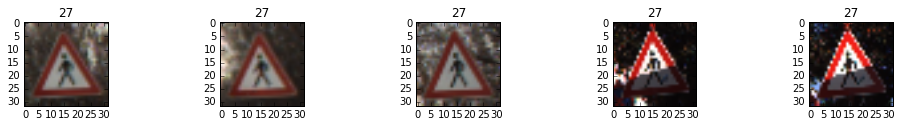

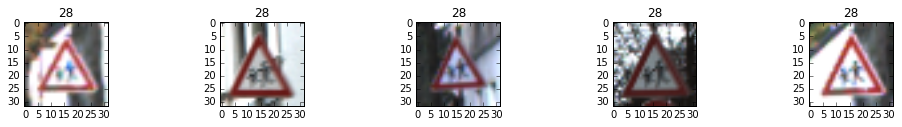

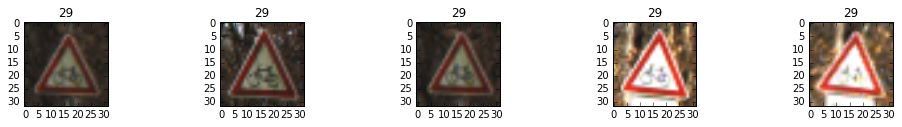

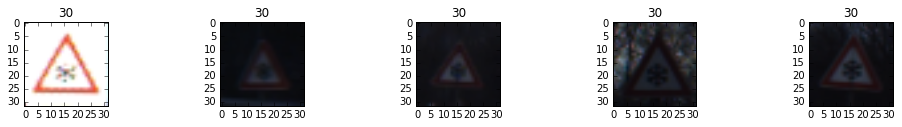

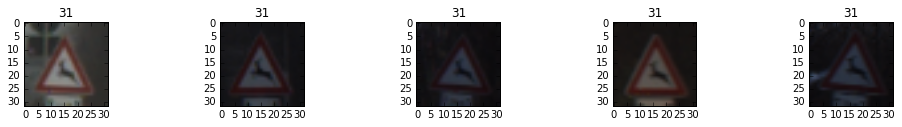

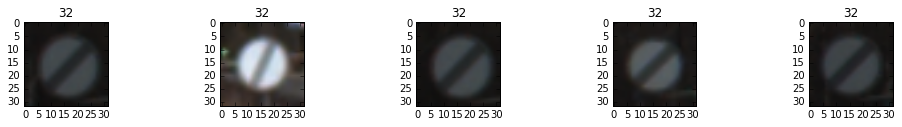

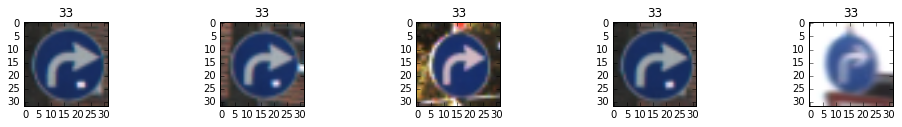

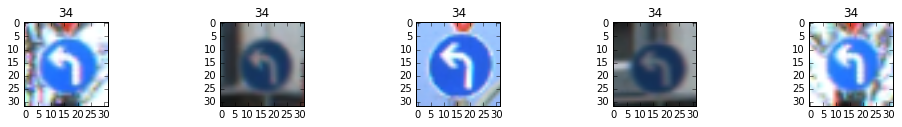

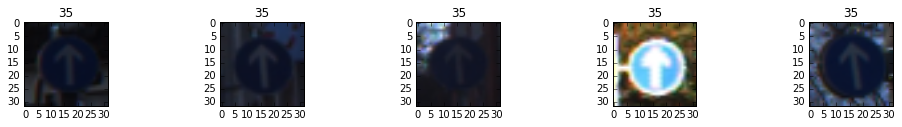

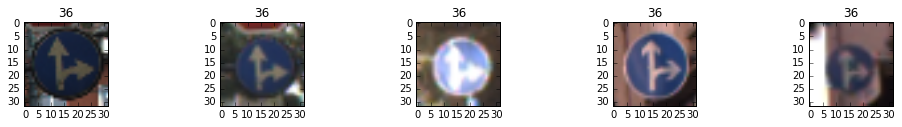

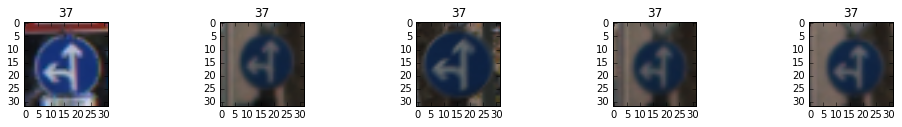

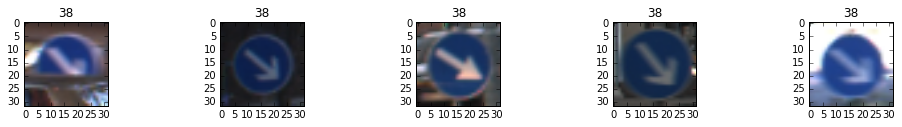

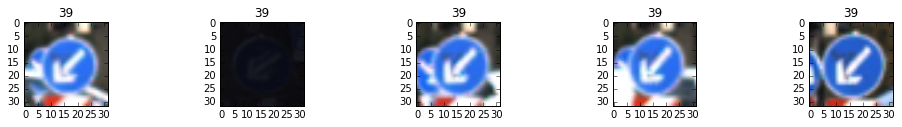

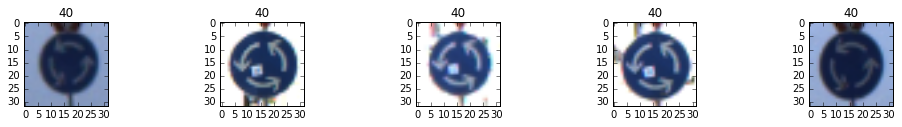

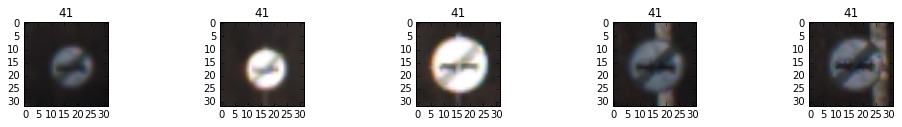

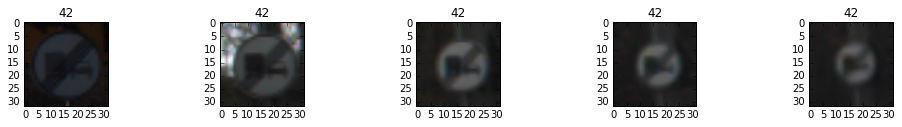

In [32]:
for i in range(n_classes):
    utils.show_img(X_test[y_test == i],
                   y_test[y_test == i], rows=1)

In [33]:
utils.basic_info(X_train)
utils.basic_info(X_test)

uint8 (39209, 32, 32, 3) Min 0 Max 255 Mean 82.67 std 69.0
uint8 (12630, 32, 32, 3) Min 0 Max 255 Mean 82.15 std 69.0


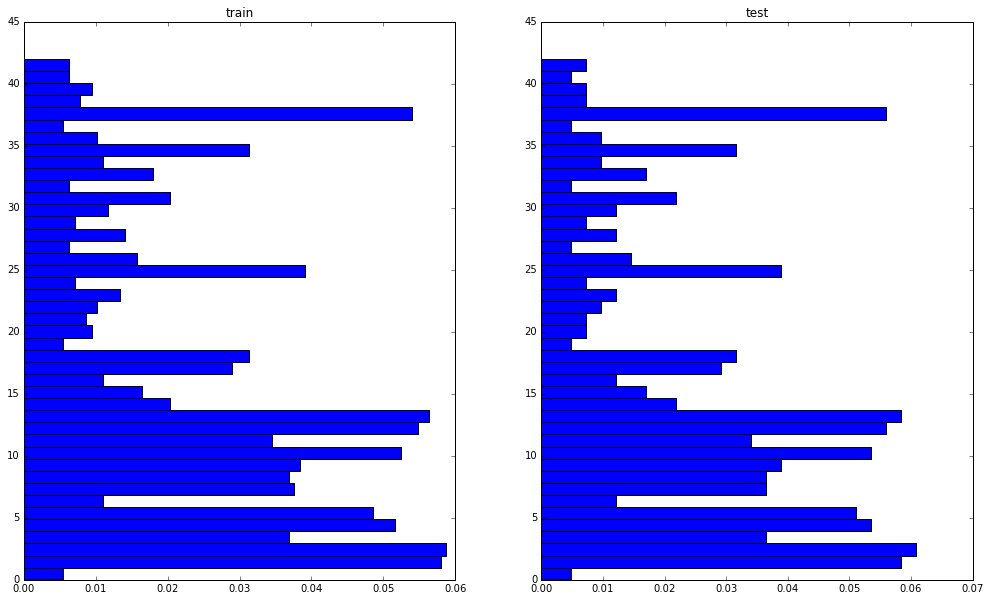

In [34]:
f, (ax1, ax2) = plt.subplots(1, 2)
f.set_size_inches(17, 10)
ax1.hist(y_train, bins=n_classes, normed=True, orientation='horizontal') ; ax1.set_title( 'train' )
ax2.hist(y_test, bins=n_classes, normed=True, orientation='horizontal') ; ax2.set_title( 'test' )
plt.show()

Speed limit (20km/h) Dangerous curve to the left


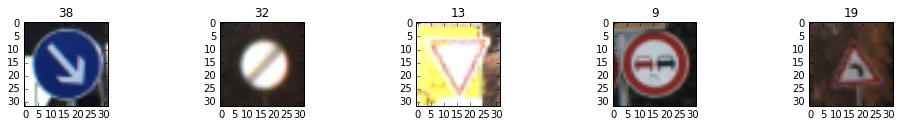

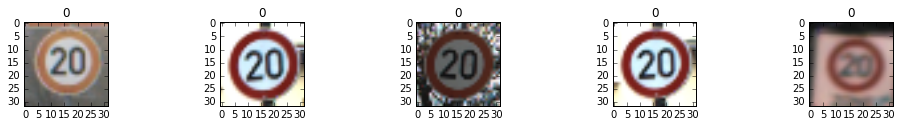

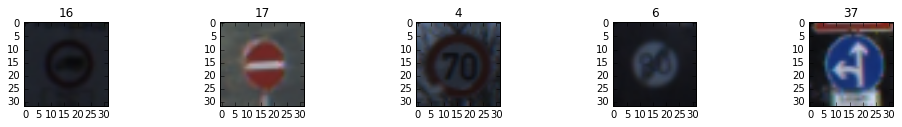

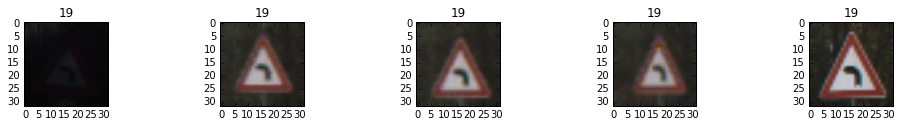

In [35]:
print(translate[0], translate[19])
utils.show_img(X_train, y_train, 1)
utils.show_img(X_train[y_train == 0], y_train[y_train == 0], 1)
utils.show_img(X_test, y_test, 1)
utils.show_img(X_test[y_test == 19], y_test[y_test == 19], 1)

In [36]:
####### Grayscaled #######
train_data = utils.np2grayscale(X_train).reshape(-1, image_shape[1], image_shape[1], 1)
test_data = utils.np2grayscale(X_test).reshape(-1, image_shape[1], image_shape[1], 1)

print('train grayscale', end=' --> ') ; utils.basic_info(X_train)
print('test grayscale', end=' --> ') ; utils.basic_info(X_test)

train grayscale --> uint8 (39209, 32, 32, 3) Min 0 Max 255 Mean 82.67 std 69.0
test grayscale --> uint8 (12630, 32, 32, 3) Min 0 Max 255 Mean 82.15 std 69.0


In [37]:
####### Add extra samples where they are less than major, rotate, shift and flip randomly all of samples #######
(train_data, valid_data,
 train_lables, valid_lables,) = train_test_split(train_data, y_train, test_size=0.08, random_state=49)


#### Create generator object for testing samples later. 
print('Fitting datasets. This may take some time.')
train_data, train_lables, datagen = utils.prepare_training_data(train_data, train_lables, 1000)
valid_data, valid_lables, _ = utils.prepare_training_data(valid_data, valid_lables, 0)
test_data, test_lables = utils.preprocess_images(test_data, y_test)

train_data = train_data.astype(np.float32)
valid_data = valid_data.astype(np.float32)
test_data = test_data.astype(np.float32)

print('\ntrain', end=' --> ') ; utils.basic_info(train_data)
print('valid', end=' --> ') ; utils.basic_info(valid_data)
print('test', end=' --> ') ; utils.basic_info(test_data)

print("\nLables :\n")
print(train_lables.shape)
print(valid_lables.shape)
print(test_lables.shape)

Fitting datasets. This may take some time.

train --> float32 (48211, 32, 32, 1) Min -1.5299999713897705 Max 3.880000114440918 Mean 0.0 std 1.0
valid --> float32 (3137, 32, 32, 1) Min -1.4900000095367432 Max 3.890000104904175 Mean 0.0 std 1.0
test --> float32 (12630, 32, 32, 1) Min -1.5 Max 3.880000114440918 Mean -0.0 std 1.0

Lables :

(48211,)
(3137,)
(12630,)


Notice training dataset now have much more even distribution between each class.




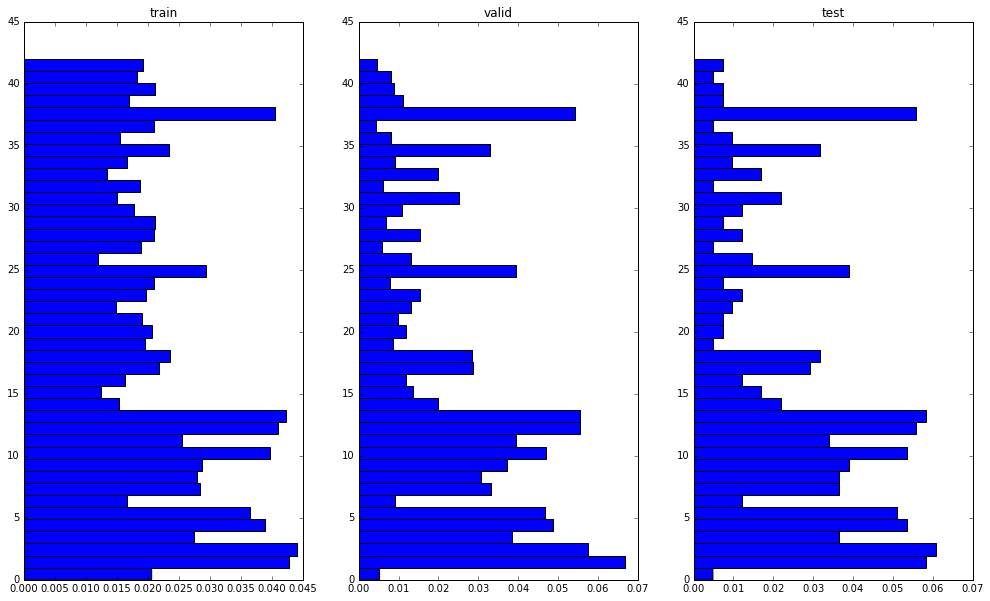

In [38]:
print('Notice training dataset now have much more even distribution between each class.\n\n')
f, (ax1, ax2, ax3) = plt.subplots(1, 3)
f.set_size_inches(17, 10)
ax1.hist(train_lables, bins=n_classes, normed=True, orientation='horizontal') ; ax1.set_title( 'train' )
ax2.hist(valid_lables, bins=n_classes, normed=True, orientation='horizontal') ; ax2.set_title( 'valid' )
ax3.hist(test_lables, bins=n_classes, normed=True, orientation='horizontal') ; ax3.set_title( 'test' )
plt.show()

5 random train dataset samples:


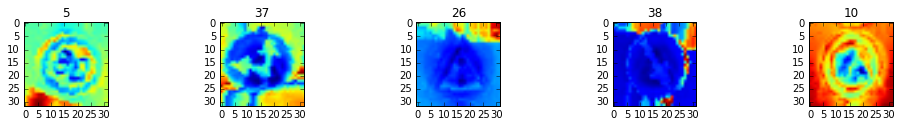

5 random train dataset with lable = 0 samples:


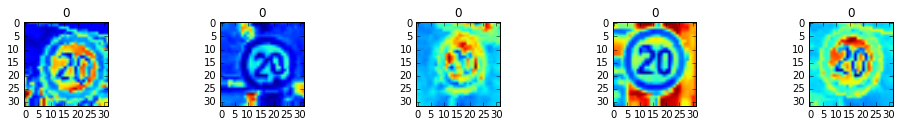

5 random test dataset samples:


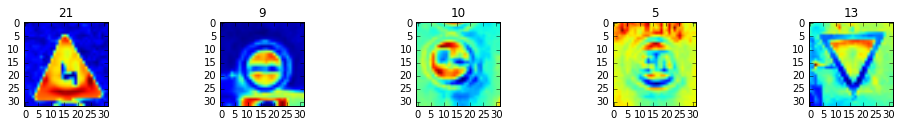

5 random test dataset with lable = 0 samples:


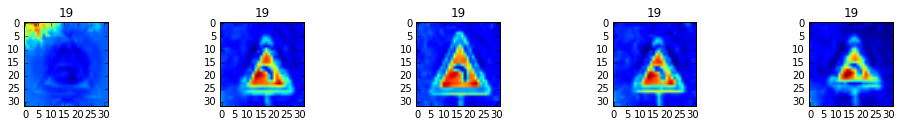

In [39]:
print('5 random train dataset samples:')
utils.show_img(train_data[:,:,:,0], train_lables, 1)
print('5 random train dataset with lable = 0 samples:')
utils.show_img(train_data[train_lables == 0][:,:,:,0], train_lables[train_lables == 0], 1)
print('5 random test dataset samples:')
utils.show_img(test_data[:,:,:,0], test_lables, 1)
print('5 random test dataset with lable = 0 samples:')
utils.show_img(test_data[test_lables == 19][:,:,:,0], test_lables[test_lables == 19], 1)

### LBP (Local Binary Pattern) channel

Attempt to add second channel for all images which could give more accurate predictions. I did try train also with second channel but afterwards I made some major changes in preprocessing and got more decent results so didn't try again same thing with second LBP channel. I believe that it could boost accuracy but so as calculation time. Because of that and because I wanted spend no more time on this I skipped this step.

In [40]:
###### with extra LBP channels #######
#train_data_lbp = utils.add_lbp_channel_and_norm(train_data)
#valid_data_lbp = utils.add_lbp_channel_and_norm(valid_data)
#test_data_lbp = utils.add_lbp_channel_and_norm(test_data)

#(train_data_lbp, valid_data_lbp,
# _, _,) = train_test_split(train_data_lbp, y_train, test_size=0.05, random_state=49)

#print()
#print('train with lbp channel', end=' --> ') ; utils.basic_info(train_data_lbp)
#print('valid with lbp channel', end=' --> ') ; utils.basic_info(valid_data_lbp)
#print('test with lbp channel', end=' --> ') ; utils.basic_info(test_data_lbp)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

However, we are also looking for some justification for these choices -

**1.Conversion to grayscale**

_Converted to grayscale because when I looked through images I noticed that all of traffics signs actually have different shaping and none of traffic sign is different from other because of color. However color might be useful for some examples like class 5 and 6. I alos read in http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf that with grayscale they achieved better results - so it seems that in some cases color actually is making unnecessary noise. Grayscale results in faster computations however I haven't tested how big improvement is or is it even noticable in this scale._

**2.Featurewise centered**

**3.Featurewise STD normalization**

_Featurewise centered - sets mean value to 0 for whole dataset. Featurewise STD normalization - sets standard deviation of 1 for whole dataset._

_Basic idea behind both operations is to give each feature same meaning for whole dataset. For example it may differ how image is loaded into numpy array or image itself may have different original format such as 'jpeg' and 'png' - with those operations we can apply same weights to different images._

_Why feature wise and not sample wise ? - I thought it is very important that all feature values have same meaning for whole dataset and not just for image itself. With those operations I thought it is possible to point out different features for each class more easily for classifier._

# Do not run this cell below twice in same session. :)

In [41]:
import tensorflow as tf
import math

working_dir = '../P2-Traffic-Sign-Classifier/'

train_lables = (np.arange(n_classes) == train_lables[:,None]).astype(np.float32)
valid_lables = (np.arange(n_classes) == valid_lables[:,None]).astype(np.float32)
test_lables = (np.arange(n_classes) == test_lables[:,None]).astype(np.float32)

print('New shapes of all lables (one hot encoding) :\n')
print('train :',train_lables.shape)
print('valid :',valid_lables.shape)
print('test :',test_lables.shape)

New shapes of all lables (one hot encoding) :

train : (48211, 43)
valid : (3137, 43)
test : (12630, 43)


Some helping fucions

In [42]:
import time
batch_size = 64

def wrong_classified(batch_data,batch_lables,predictions,retrain_set):
    false = np.argmax(batch_lables, 1) == np.argmax(predictions, 1)

    bd = batch_data[false == False]
    bl = batch_lables[false == False]
    p = predictions[false == False]

    #print(lable(bl,p,0))

    data,labels = retrain_set

    if data.shape[0] != 0:
        data = np.concatenate((data,bd),axis=0)
        labels = np.concatenate((labels,bl),axis=0)
    else:
        data = bd
        labels = bl

    return data,labels

def show_wrong(batch_data, batch_lables, predictions, push_to_go = True):
    false = np.argmax(batch_lables, 1) == np.argmax(predictions, 1)
    
    bd = batch_data[false == False]
    bl = batch_lables[false == False]
    p = predictions[false == False]
    
    for i in range(0, len(bl), 5):
        if len(bl) < 5:
            rng = len(bl)
        else:
            rng = 5
        
        labels = ['{} not {}'.format(np.argmax(bl[i+ii]), np.argmax(p[i+ii])) for ii in range(rng)]
        
        print(bd[i:i+5,:,:,0].shape)
        utils.show_img(bd[i:i+5,:,:,0], labels)
        
        if push_to_go:
            pressed_key = input("press any key")
            clear_output()

In [43]:
def cnn4(train_dataset, train_lables, valid_data, valid_lables, retrain=False, num_steps = 1001,
          l_start = 0.005, drop_out_c = 0.5,debug_dataset=False,
          l2_rc = 0.1, ch_name = 'model', tuning_params = None):
    
    w1_depth, w2_depth, fltr, l2_rc, drop_out_c = tuning_params
    checkpoint_file = working_dir + ch_name
    
    print('Image height:', train_dataset.shape[1],'Image width:', train_dataset.shape[2],
          'Classes :', train_lables.shape[1],'Channels :', train_dataset.shape[-1])
    
    print('Dropout:', drop_out_c, 'l2_rc', l2_rc)
    
    gpuOptions = tf.GPUOptions(allow_growth = True)
    tf.reset_default_graph() #reset graph, remove previous created variables

    retrain_set = np.array([]),np.array([]) #data/labels
    
    #with tf.variable_scope('cnn9'):

    # Input data.
    with tf.name_scope('input'):
        tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, train_dataset.shape[1], train_dataset.shape[2], train_dataset.shape[-1]))
        tf_train_lables = tf.placeholder(tf.float32, shape=(batch_size, n_classes))
        tf_valid_dataset = tf.constant(valid_data)
    
    with tf.name_scope('dout_prob'):
        keep_prob = tf.placeholder(tf.float32)

    # Variables
    # Convolutions part
    w1 = tf.Variable(tf.truncated_normal([fltr, fltr, train_dataset.shape[-1], w1_depth], stddev=0.1),name='w1')
    b1 = tf.Variable(tf.zeros([w1_depth]),name='b1')
    
    w2 = tf.Variable(tf.truncated_normal([fltr, fltr, w1_depth, w2_depth], stddev=0.1),name='w2')
    b2 = tf.Variable(tf.constant(1.0, shape=[w2_depth]),name='b2')

    w3 = tf.Variable(tf.truncated_normal([fltr, fltr, w2_depth, w2_depth], stddev=0.1),name='w3')
    b3 = tf.Variable(tf.constant(1.0, shape=[w2_depth]),name='b3')

    conv_to_full = 16384

    # Fully Connected part
    w4 = tf.Variable(tf.truncated_normal([conv_to_full, 128], stddev=utils.std(conv_to_full)),name='w4')
    b4 = tf.Variable(tf.constant(1.0, shape=[128]),name='b4')

    w5 = tf.Variable(tf.truncated_normal([128, n_classes], stddev=utils.std(128)),name='w5')
    b5 = tf.Variable(tf.constant(1.0, shape=[n_classes]),name='b5')

    # Model.
    def model(data):
        #### 1. stage ####
        with tf.name_scope('layer_1'):
            c1 = tf.nn.conv2d(data, w1, [1, 1, 1, 1], padding='SAME') #convolution 1
            print('c1',c1.get_shape().as_list())

            h1 = tf.nn.relu(c1 + b1) #hidden layer 1
            p1 = tf.nn.max_pool(h1,ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME') #pool 1

            print('p1',p1.get_shape().as_list())

        with tf.name_scope('layer_2'):
            c2 = tf.nn.conv2d(p1, w2, [1, 1, 1, 1], padding='SAME')
            h2 = tf.nn.relu(c2 + b2)
            p2 = tf.nn.max_pool(h2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
            print('p2', p2.get_shape().as_list())

        with tf.name_scope('layer_3'):
            #### 2. stage ####
            c3 = tf.nn.conv2d(p2, w3, [1, 1, 1, 1], padding='SAME')
            h3 = tf.nn.relu(c3 + b3)

        #### Classifier ####
        with tf.name_scope('concat'):
            print('h3', h3.get_shape().as_list())
            concat = tf.concat(3, [p2,h3], name='concat')
            print('concat', concat.get_shape().as_list())

            flatten = tf.contrib.layers.flatten(concat)
            print('flatten', concat.get_shape().as_list())
        
        with tf.name_scope('layer_4'):
            f4 = tf.nn.relu(tf.matmul(flatten, w4) + b4)
        
        with tf.name_scope('dropout'):
            d4 = tf.nn.dropout(f4, keep_prob)
            print('d4',d4.get_shape().as_list())
            print('flatten --> w4 {} --> {}'.format(flatten.get_shape().as_list(),w4.get_shape().as_list()))
        
        with tf.name_scope('logits'):
            return tf.matmul(d4, w5) + b5

    # Training computation.
    logits = model(tf_train_dataset)
    print('logits', logits.get_shape().as_list())
    
    with tf.name_scope('loss_l2'):
        # L2 Regularization -> tf.nn.l2_loss(weights) -> penelazies large weigths
        regularizers = (tf.nn.l2_loss(w1) + tf.nn.l2_loss(b1)
                        + tf.nn.l2_loss(w2) + tf.nn.l2_loss(b2)
                        + tf.nn.l2_loss(w3) + tf.nn.l2_loss(b3)
                        + tf.nn.l2_loss(w4) + tf.nn.l2_loss(b4)
                        + tf.nn.l2_loss(w5) + tf.nn.l2_loss(b5))
    
    
        print('regularizers', regularizers)
        loss = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_lables))
        print('loss', loss)
        loss = loss + (l2_rc*regularizers)
        print('loss_l2', loss)
        optimizer = tf.train.AdamOptimizer(learning_rate=l_start).minimize(loss)
    
    with tf.name_scope('softmax_train'):
        train_prediction = tf.nn.softmax(logits)
    
    with tf.name_scope('softmax_valid'):
        valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
        
    init_d = tf.initialize_all_variables()
    
    with tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                         gpu_options=gpuOptions)) as session:
    #session = tf.Session()
        init_d.run()
    #writer = tf.train.SummaryWriter(working_dir + 'tf_logs/', session.graph)

        try:
            saver = tf.train.Saver()
            saver.restore(session, checkpoint_file + '.chk')
            print('Using Saver weights and biases')
        except Exception as e:
            pass
            print('Using New weights and biases {}'.format(e))

        print('Initialized')
        try:
            print('\nStep  Loss     LR             Train   Valid   Time')
            for step in range(num_steps):
                start_time = time.time()
                offset = (step * batch_size) % (train_lables.shape[0] - batch_size)

                batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
                batch_lables = train_lables[offset:(offset + batch_size), :]

                feed_dict = {tf_train_dataset : batch_data, tf_train_lables : batch_lables, keep_prob: drop_out_c}
                _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)

                learn_rate = 0
                feed_dict_eval = {keep_prob: 1.0} #Turn off dropout for valid and test

                #collect wrong classifed and then retrain with them
                if retrain:
                    retrain_set = wrong_classified(batch_data,batch_lables,predictions,retrain_set)

                if debug_dataset:
                    ####  Includes lot of manual processing.
                    show_wrong(batch_data, batch_lables, predictions)

                if step % 100 == 0:
                    end_time = time.time() - start_time
                    valid_acc = utils.accuracy(valid_prediction.eval(feed_dict=feed_dict_eval),valid_lables)
                    print((str(step).ljust(6) + '%.5f' + '  %.10f' + '   %.1f%%' + '   %.1f%%' + '   %.2f') %
                          (l,learn_rate, utils.accuracy(predictions, batch_lables), valid_acc, end_time))
                    if valid_acc > 98.9:
                        raise KeyboardInterrupt

            var_list = tf.all_variables()
            utils.save(checkpoint_file, session,var_list)
        except KeyboardInterrupt:
            writer.flush()
            var_list = tf.all_variables()
            utils.save(checkpoint_file, session,var_list)

        session.close()
        print('\n\nRetrain dataset :',retrain_set[0].shape, 'Labels :', retrain_set[1].shape)
        return retrain_set

_It is possible to run ccn4 also without tuning params parameters. I just made it for multiple and long calucaltions to tune hyperparameters._

You'll notice alot of printouts at the start. With this information it was more easy to debug and understand network.

Also notice retrain_data set which was made for bootstrapping. I used it at some point but didn't use it at the end because of population of additional data, decent results and because I wanted to move on for more important projects. :)

In [45]:
print('Example of training process for 1001 epochs..')
params = [(64, 128, 4, 0.0005, 0.85)]

for p in params:
    print('Params ----------->', p)
    with tf.device('/cpu:0'):
        cnn4(train_data, train_lables, valid_data, valid_lables, l_start = 0.0005,
             num_steps = 1001 , debug_dataset = False, drop_out_c=1,
             l2_rc = 0.005, ch_name = 'ch1_{}'.format(p), tuning_params = p)

Example of training process for 1001 epochs..
Params -----------> (64, 128, 4, 0.0005, 0.85)
Image height: 32 Image width: 32 Classes : 43 Channels : 1
Dropout: 0.85 l2_rc 0.0005
c1 [64, 32, 32, 64]
p1 [64, 16, 16, 64]
p2 [64, 8, 8, 128]
h3 [64, 8, 8, 128]
concat [64, 8, 8, 256]
flatten [64, 8, 8, 256]
d4 [64, 128]
flatten --> w4 [64, 16384] --> [16384, 128]
logits [64, 43]
regularizers Tensor("loss_l2/add_8:0", shape=(), dtype=float32)
loss Tensor("loss_l2/Mean:0", shape=(), dtype=float32)
loss_l2 Tensor("loss_l2/add_9:0", shape=(), dtype=float32)
c1 [3137, 32, 32, 64]
p1 [3137, 16, 16, 64]
p2 [3137, 8, 8, 128]
h3 [3137, 8, 8, 128]
concat [3137, 8, 8, 256]
flatten [3137, 8, 8, 256]
d4 [3137, 128]
flatten --> w4 [3137, 16384] --> [16384, 128]
Using Saver weights and biases
Initialized

Step  Loss     LR             Train   Valid   Time
0     0.17213  0.0000000000   100.0%   97.8%   0.06
100   0.21421  0.0000000000   98.4%   97.2%   0.01
200   0.18904  0.0000000000   100.0%   97.8%   0.

### Visualizing network graph as suggested.

So I took "To add an extra punch to your report, you may consider adding a visualization of the entire final network showing the connections between the layers." seriously and made some changes for network to display it properly in TensorBoard - for this I had to re-train my network again but this time I didn't wait long enough to get 96% on test data. I still think that something is wrong with image preprocessing that I cannot achieve 99% on Test data.


Network looks similar to one as in http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf described.

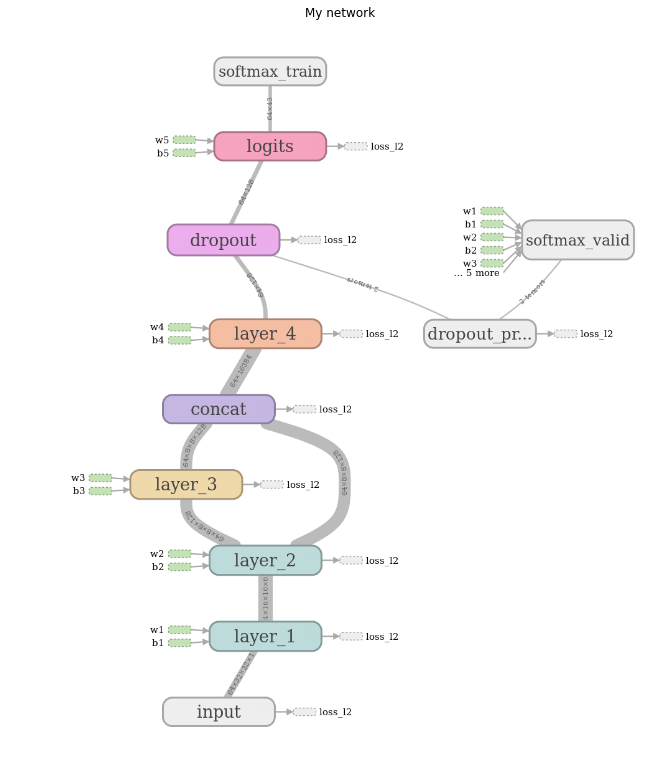

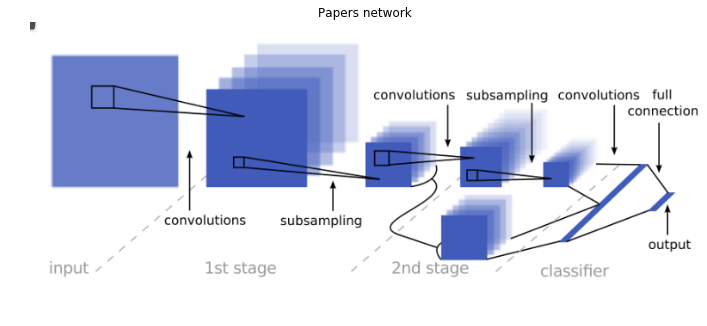

In [71]:
import matplotlib.image as mpimg

net_0 = mpimg.imread('network.png')
net_1 = mpimg.imread('net_0.png')

f, (ax1) = plt.subplots(1, 1)
f.set_size_inches(16,13)
ax1.imshow(net_0)
ax1.set_title('My network')
plt.axis('off')
plt.show(block=False)
f, (ax1) = plt.subplots(1, 1)
f.set_size_inches(12,15)
ax1.imshow(net_1)
ax1.set_title('Papers network')
plt.axis('off')
print()

**Why is the convolutional layer best suited here?**

Convolutions are very goot at finding shapes and structures. It starts with little detales like edges and lines and as deeper convolutions go it starts to learn shape of for example STOP sign. Layer after layer for convolutions we are reducing size of image, making most important feature to go further. Best thing about convolutions is that it can learn to recognize objects in any place in image.

**What's the role of the dropout layer? Do you think the model is overfitting? Why?**

Model is overfitting because my validation set did not reach more that 94% accuracy while on training data there already was 100% continuously. After setting dropout to 0.8 I was able to reach more than 98% on validation set.

**Why choose the RELU activation?**

RELU has proven that it yields higher accuracy than Sigmoid, in practice I also noticed that 'recently' discovered ELU does not make anything better instead sometimes it shows worsen results. RELU also is faster (haven't tested that on TF) thanks to constant value when activation is less or equal to 0, same thing also resolves vanishing gradient issue which is common for Sigmoid.

### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**

Split data into three datasets : train_data (0.92) / valid_data (0.08) of X_train dataset and test_data from X_test dataset.

Preprocess all images:

1. convert to grayscale (OpenCV)
2. featurewise centred (Keras)
3. featurewise STD normalization (Keras)

For training/validation dataset I did additional preprocessing because it was very easy to overfit it :

1. random rotations 15 degrees (as paper suggested) (Keras)
2. random shifts up and down/left and right (as paper suggested) (Keras)
3. random rescales (zoomes) (as paper suggested) (Keras)
4. poluated dataset so that each bin would be at least of size 1000, cleary visible in hist plot above

For all random operations always used seeds so that after each run I would get same datasets.

For lables usedone-hot-encoding.

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

I generated additional data because classes wasn't even distributed and some classes was Much less than others - together with random preprocessing (on all images) I also got 'harder to overfit' dataset of more samples in total.

My first thoght was that for Validation dataset I would not need to generate additional dataset but after I got accuracy of 99.8% on original Validation dataset and 94.4% on Test dataset I also did that for Validation dataset and it gave much better sense of how precise my model is.

I also created 'debug_dataset' parameter for training function which plotted images which model failed to predict correctly. Confusion graph also helped.

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

My final model already is seen above.

Basically I did what paper suggested with some little tweaks such as l2 regularization and DropOut (and extra fully connected layer at the end). Also used different filter sizes and parameter counts which seemed to work better for me but obviously not better than results posted in paper.

Training process was +/- automated by making list of parameters and then just iterate them.

I could have used much larger network but priority wasn't just accuracy but also how fast model can process one image. Result ~0.01s per 64 images -> 0.00016s per image. It's important because at the end we want to use those models to make predictions in real time on limited hardware.

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


At the start I set learning rate manually using decay approach bet then reallized that AdamOptimizer works better and I don't have days to figure out right way to initilize and reduce learning rate.

Batch size of 64 for fast and robust learning. Tried also 128 because I though it would make learning more stable at the and but it did not.

Epochs : early stopping by either interrupitng process by my self or it reached certain goal which is defined in learning fuction. Usually it's about 30 to 50k.

Other parameters such as filter sizes, depths etc. I stored in lists and then iterated them to see which gave best results.

### Question 5


_What approach did you take in coming up with a solution to this problem?_

I used many approaches, different nets but concluded in the end that I do not have to recreate bycicle from scratch and instead used information available in paper provided in notebook.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [24]:
def cnn4(test_data, ch_name = 'model'):
    
    checkpoint_file = working_dir + ch_name
    
    print('Image height:', test_data.shape[1],'Image width:', test_data.shape[2],
          'Classes :', test_data.shape[1],'Channels :', test_data.shape[-1])
    
    tf.reset_default_graph() #reset graph, remove previous created variables

    # Input data.
    with tf.name_scope('input'):
        tf_test_dataset = tf.placeholder(tf.float32, shape=(None, test_data.shape[1], test_data.shape[2], test_data.shape[-1]))
    # Variables
    # Convolutions part
    w1 = tf.Variable(tf.truncated_normal([4, 4, test_data.shape[-1], 64], stddev=0.1),name='w1')
    b1 = tf.Variable(tf.zeros([64]),name='b1')

    w2 = tf.Variable(tf.truncated_normal([4, 4, 64, 128], stddev=0.1),name='w2')
    b2 = tf.Variable(tf.constant(1.0, shape=[128]),name='b2')

    w3 = tf.Variable(tf.truncated_normal([4, 4, 128, 128], stddev=0.1),name='w3')
    b3 = tf.Variable(tf.constant(1.0, shape=[128]),name='b3')

    conv_to_full = 16384

    # Fully Connected part
    w4 = tf.Variable(tf.truncated_normal([conv_to_full, 128], stddev=utils.std(conv_to_full)),name='w4')
    b4 = tf.Variable(tf.constant(1.0, shape=[128]),name='b4')

    w5 = tf.Variable(tf.truncated_normal([128, n_classes], stddev=utils.std(128)),name='w5')
    b5 = tf.Variable(tf.constant(1.0, shape=[n_classes]),name='b5')

    # Model.
    def model(data):
        #### 1. stage ####
        with tf.name_scope('layer_1'):
            c1 = tf.nn.conv2d(data, w1, [1, 1, 1, 1], padding='SAME')
            h1 = tf.nn.relu(c1 + b1) #hidden layer 1
            p1 = tf.nn.max_pool(h1,ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

        with tf.name_scope('layer_2'):
            c2 = tf.nn.conv2d(p1, w2, [1, 1, 1, 1], padding='SAME')
            h2 = tf.nn.relu(c2 + b2)
            p2 = tf.nn.max_pool(h2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        
        #### 2. stage ####
        with tf.name_scope('layer_3'):
            c3 = tf.nn.conv2d(p2, w3, [1, 1, 1, 1], padding='SAME')
            h3 = tf.nn.relu(c3 + b3)

        #### Classifier ####
        with tf.name_scope('concat'):
            concat = tf.concat(3, [p2,h3], name='concat')
            flatten = tf.contrib.layers.flatten(concat)
        
        with tf.name_scope('layer_4'):
            f4 = tf.nn.relu(tf.matmul(flatten, w4) + b4)
        
        with tf.name_scope('logits'):
            return tf.matmul(f4, w5) + b5

    # Training computation.
    logits = model(tf_test_dataset)
    
    with tf.name_scope('softmax_test'):
        test_prediction = tf.nn.softmax(logits)
    
    sess = tf.InteractiveSession()
    saver = tf.train.Saver()
    saver.restore(sess, checkpoint_file + '.chk')
    
    writer = tf.train.SummaryWriter(working_dir + 'tf_logs/', sess.graph)
    
    return tf_test_dataset, test_prediction, sess 

Image height: 32 Image width: 32 Classes : 32 Channels : 1
float32 (12630, 32, 32, 1) Min -1.5 Max 3.880000114440918 Mean -0.0 std 1.0
float32 (48211, 32, 32, 1) Min -1.5299999713897705 Max 3.880000114440918 Mean 0.0 std 1.0
float32 (3137, 32, 32, 1) Min -1.4900000095367432 Max 3.890000104904175 Mean 0.0 std 1.0


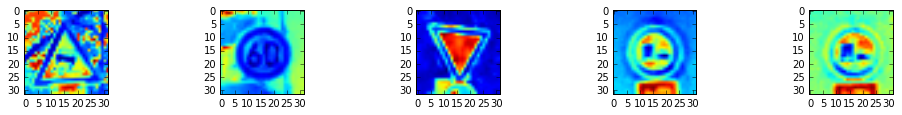

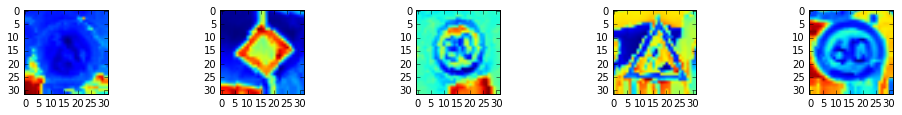

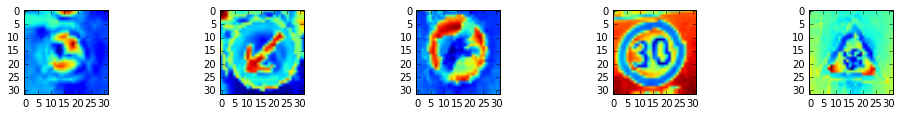

95.249406175771966

In [25]:
holder, predictor, session  = cnn4(test_data, 'best')

utils.basic_info(test_data)
utils.basic_info(train_data)
utils.basic_info(valid_data)

utils.show_img(test_data[:,:,:,0], rows=1)
utils.show_img(train_data[:,:,:,0], rows=1)
utils.show_img(valid_data[:,:,:,0], rows=1)

predictions = np.zeros((test_data.shape[0],n_classes))
for batch_size in range(0,len(test_data),3000):
    predictions[batch_size:batch_size+3000] = session.run(predictor, {holder : test_data[batch_size:batch_size+3000]})

utils.accuracy(predictions, test_lables)

**Please be sure to compare the accuracy of the model when used for the new images to the case when tested on the dataset.**

As you can see I was able to reach only 95.25% accuracy on test datase which is bad if I compare to Validation set accuracy (97.8% this time because of very small l2 regularization). Before I redisgned network to display it in Tensorboard I was able to reach 99% on Validation set and 96% on test dataset. It is huge difference ~3%.

What can be done ? :

1. In my opinion better preprocessing should yield most improvement - additional (smarter) data. To at least reduce difference of accuracy I get on training/validation set and test set. Let's say to 1.5%.
2. Extra LBP (decribed at the start of this ipynb) channel also might help to get better results.
3. I'm 100% sure that my network is not configure correcly when speaking about hypterparameters. It takes alot of time to set them just right.
4. Maybe I should choose normalization after some layers ?
5. Of-course there are always place to try different networks. If I would go with this to production I would definitely try first some pretrained models and well known archirectures for this issue.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._

**Answer:**

## Note : I chose onlly traffic signs which are classified in classifier. And all them placed in Latvia (where I'm from).

I prepared this dataset same as training data to make more difficult for model to recognize.

float64 (10, 32, 32) Min 5.0 Max 255.0 Mean 135.06 std 70.0


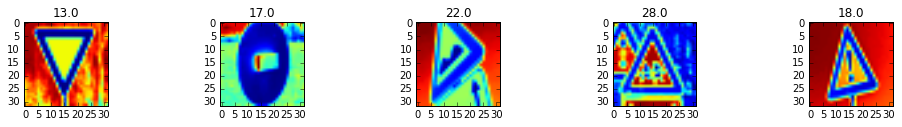

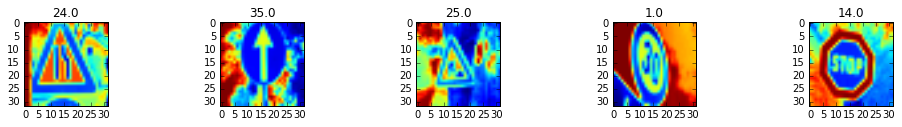

-------------------------------------------------------------------------------------------------------------------


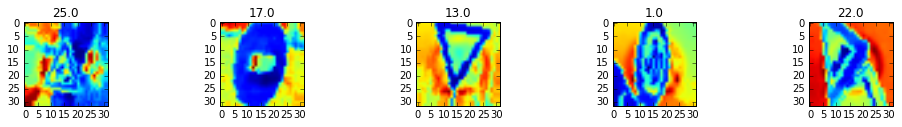

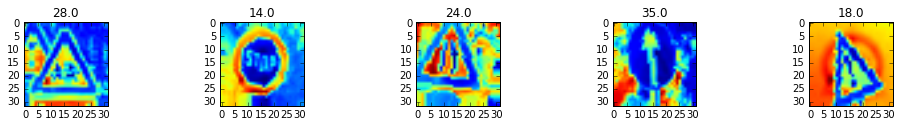

-------------------------------------------------------------------------------------------------------------------
float32 (10, 32, 32, 1) Min -1.2000000476837158 Max 3.6600000858306885 Mean 0.7799999713897705 std 1.0
(10, 43)


In [28]:
import os
import scipy

im_dir = '../P2-Traffic-Sign-Classifier/test_imgs/'
files = os.listdir(im_dir)

fl_size = len(files)

images = np.zeros((fl_size, 32, 32))
labels = np.zeros((fl_size,))
del_list = []
for i in range(fl_size):
    if '.jpg' in files[i]:
        labels[i] = files[i].split('.')[0]
        images[i] = scipy.misc.imresize(cv2.imread(im_dir + files[i], 0), (32, 32))
    else:
        del_list.append(i)

images = np.delete(images, del_list, axis=0)
labels = np.delete(labels, del_list, axis=0)
        
utils.basic_info(images)

images = images.reshape(-1, image_shape[1], image_shape[2], 1)

utils.show_img(images[:,:,:,0], labels, rows=2)

scipy.misc.imsave('sample_0.jpg', images[0,:,:,0])

images, labels = utils.preprocess_images(images, labels, datagen)
labels_hot = (np.arange(n_classes) == labels[:,None]).astype(np.float32)

scipy.misc.imsave('sample_1.jpg', images[6,:,:,0])
images = images.astype(np.float32)
scipy.misc.imsave('sample_2.jpg', images[6,:,:,0])

print('-'*115)
utils.show_img(images[:,:,:,0], labels, rows=2)
print('-'*115)
utils.basic_info(images)
print(labels_hot.shape)

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset?_


**Answer:**

(5, 32, 32)


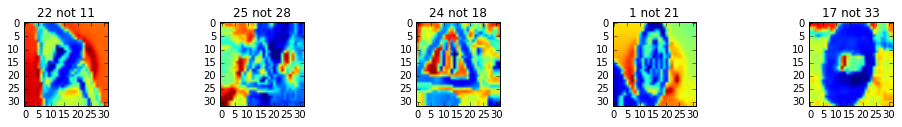

In [36]:
sample_preds = session.run(predictor, {holder : images})
utils.accuracy(sample_preds, labels_hot)
show_wrong(images, labels_hot, sample_preds, False)

Above we can see that model does not perform equally well on samples provided. One reason might be that they are different formatted, have different positions and styles such as fith pictre have complitley different style of original 17.

Lable of image : left side is original lable and right side is predicted lable.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

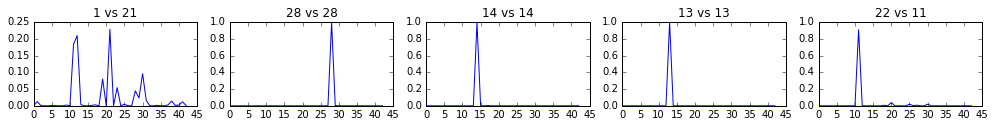

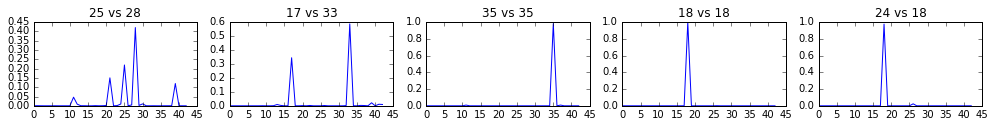

In [45]:
for i in range(0,len(sample_preds), 5):
    f, (ax1, ax2, ax3,ax4,ax5) = plt.subplots(1, 5)
    f.set_size_inches(17,1.5)

    ax1.plot(sample_preds[i])
    ax2.plot(sample_preds[i+1])
    ax3.plot(sample_preds[i+2])
    ax4.plot(sample_preds[i+3])
    ax5.plot(sample_preds[i+4])
    
    ax1.set_title(str(np.argmax(labels_hot[i])) + ' vs ' + str(np.argmax(sample_preds[i])))
    ax2.set_title(str(np.argmax(labels_hot[i+1])) + ' vs ' + str(np.argmax(sample_preds[i+1])))
    ax3.set_title(str(np.argmax(labels_hot[i+2])) + ' vs ' + str(np.argmax(sample_preds[i+2])))
    ax4.set_title(str(np.argmax(labels_hot[i+3])) + ' vs ' + str(np.argmax(sample_preds[i+3])))
    ax5.set_title(str(np.argmax(labels_hot[i+4])) + ' vs ' + str(np.argmax(sample_preds[i+4])))

From this we can can see that classifier tend to "struggle" more where there are wrong predictions - this we can see for 1,6 and 7. For 1 it appears in plot but with very small confidence. For 6 and 7 it is second largest probabilty - so yes.

However there are also wrong predictions for 5 and 10 samples where calssifier is very confident and there are no other predictions made.

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


Every should work just fine if you'll use files available in .zip. One important note however is that you must run all cells before running other cells later because they depends and previous outputs.

Basically workflow is simple - just Shift+Enter through Jupyter notebook.

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.